# Can we predict whether someone will subscribe to a video game related newsletter based on age and number of hours played?

In [1]:
library(tidyverse)
library(tidymodels)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## INTRODUCTION

At UBC, a research group in the Department of Computer Science is collecting data on video games, or more specifically, how people play them. However, researching this takes a lot of effort, so being able to focus on players who play more often, as well as getting a better idea of gamer demographics overall is beneficial. One possible indiciation of video game interest is whether or not someone subscribes to a video game newsletter, which is what this project will focus on predicting through several variables: can the age and number of hours played predict whether someone will subscribe to a video game newsletter? These predictors were chosen for several reasons. Age could impact interest levels in newsletters; perhaps only certain generations take interest in them. Hours played could be an indication of interest level in videogames, which may also encourage newsletter subscription. 

In [12]:
players <- read_csv("https://raw.githubusercontent.com/katec21/dsci-100-final-project/refs/heads/main/players.csv", show_col_types = FALSE)
head(players) 


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17



This project will use data on player demographics, with 196 observations. The variables include experience level, whether the person is a subscriber, their hours played, name, email, gender, and age. The variables take the type of "chr" for strings, "dbl" for numeric values, and "lgl" to indicate whether they are a subscriber (TRUE) or not (FALSE). 

In [3]:
summary_stats <- players |>
    filter(Age != "NA") |>
    select(Age, played_hours) |>
    summarize("Mean Age" = mean(Age),
              "Mean Hours Played" = mean(played_hours))
summary_stats


Mean Age,Mean Hours Played
<dbl>,<dbl>
20.52062,5.904639


The average age across the players 20.52 years old, and the average time played across the players is 5.9 hours. Note there were some N/A's in the data that needed to be filtered out. This project will involve wrangling this data drame, creating visualizations, and building a model to help answer our question: can the age and number of hours played predict whether someone will subscribe to a video game newsletter?

## METHODS AND RESULTS

First, we can clean the dataframe to include only the variables we are interested in, as well as changing the categorical variables to factor types rather than characters and logical variables:

In [4]:
players_filtered <- players |>
    filter(Age != "NA") |>
    select(subscribe, played_hours, gender, Age) |>
    mutate(subscribe = as.factor(subscribe))

head(players_filtered)



subscribe,played_hours,gender,Age
<fct>,<dbl>,<chr>,<dbl>
TRUE,30.3,Male,9
TRUE,3.8,Male,17
FALSE,0.0,Male,17
TRUE,0.7,Female,21
TRUE,0.1,Male,21
TRUE,0.0,Female,17


Next, we can make a scatterplot with age and hours played as our axes, and colour the data by whether they are a subscriber or not, to visualize whether there is any pattern in the data. Note that the y-axis is log transformed, to account for the range in hours played as some played for near 0 hours while others played for hundreds of hours. 

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


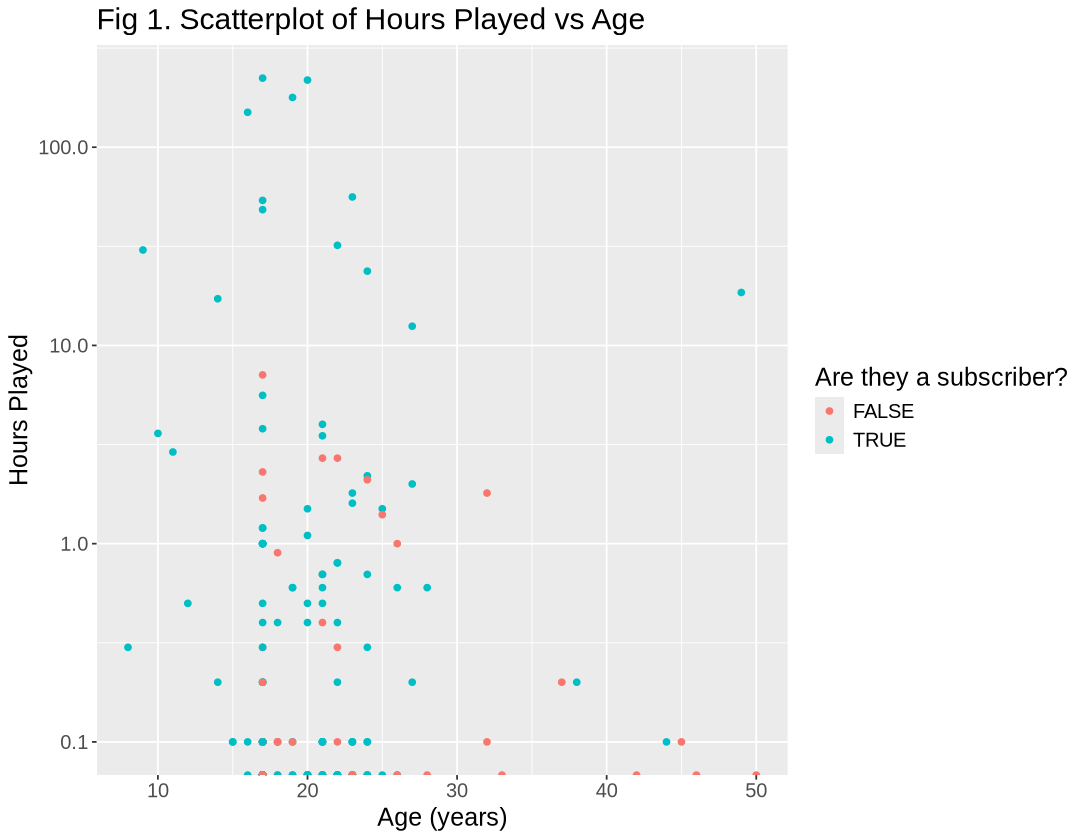

In [5]:
options(repr.plot.width = 9)

plot <- players_filtered |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(x = "Age (years)", y = "Hours Played", color = "Are they a subscriber?", title = "Fig 1. Scatterplot of Hours Played vs Age") +
    scale_y_log10() +
    theme(text = element_text(size = 15))

plot


Based on this visualization, no clear pattern is apparent, although it appears that the longer hours played are dominated by subscribers, while there are less subscribers as age increases. 

This project will use KNN classification as its model, as the goal is to classify someone as a subscriber or non-subscriber based on the predictor variables age and hours played. This model will take the specified number of nearest neighbors based on straight line distance, and classify the observation based on majority vote of the neighbors. Before creating the model, let's split the dataset into training and testing data, so that our evaluation of our model will not be affected:

In [6]:
set.seed(1234)
player_split <- initial_split(players_filtered, prop = 0.75, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)

Note that we made a 75:25 training to testing set, for a good balance of a large enough training set to train the model, while having enough data in the testing set to evaluate it. The strata argument ensures that both sets have proportionate amounts of both arguments (subscribers and non-subscribers). Also note that a seed was set, to ensure the analysis is reproducible, and the same random splitting will occur each time the code is run.
Now, we can create our recipe and model specification:

In [7]:
player_recipe <- recipe(subscribe ~ Age + played_hours, data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

player_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")


There are a few things to note:
First, the step_scale() and step_center() arguments were passed in the recipe; this is to scale and center the data. Since the hours played is on a larger numeric scale than the age, it would play a much larger role in the predicting process than the age. By scaling the data, it ensures both variables contribute to the prediction equally. Centering also ensures the variables are centred around the same mean. This again makes the two more comparable. 
Next, the number of neighbors is not specified, but rather the function tune() was passed. This is because we do not know what value of K would fit the best (we don't want to underfit or overfit the data). We should also use cross validation to find the best value of K, just in case we happen to get a bad validation set. Let's try values of k from 1 to 30 to see which has the highest accuracy.

In [8]:
set.seed(1234)
vfold <- vfold_cv(player_training, v = 5, strata = subscribe)
ks <- tibble(neighbors = 1:30)

player_fit_tune <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec_tune) |>
    tune_grid(resamples = vfold, grid = ks) |>
    collect_metrics() |>
    filter(.metric == "accuracy") 
player_fit_tune

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5175205,5,0.031652196,Preprocessor1_Model01
2,accuracy,binary,0.5034811,5,0.031535833,Preprocessor1_Model02
3,accuracy,binary,0.5512972,5,0.025487955,Preprocessor1_Model03
4,accuracy,binary,0.5724795,5,0.029637483,Preprocessor1_Model04
5,accuracy,binary,0.5936617,5,0.041829451,Preprocessor1_Model05
6,accuracy,binary,0.5869951,5,0.040766516,Preprocessor1_Model06
7,accuracy,binary,0.6210345,5,0.048369368,Preprocessor1_Model07
8,accuracy,binary,0.6143842,5,0.063595162,Preprocessor1_Model08
9,accuracy,binary,0.6074877,5,0.065635177,Preprocessor1_Model09


We can also plot the accuracy against the k values to see which k values correspond to the highest accuracy:

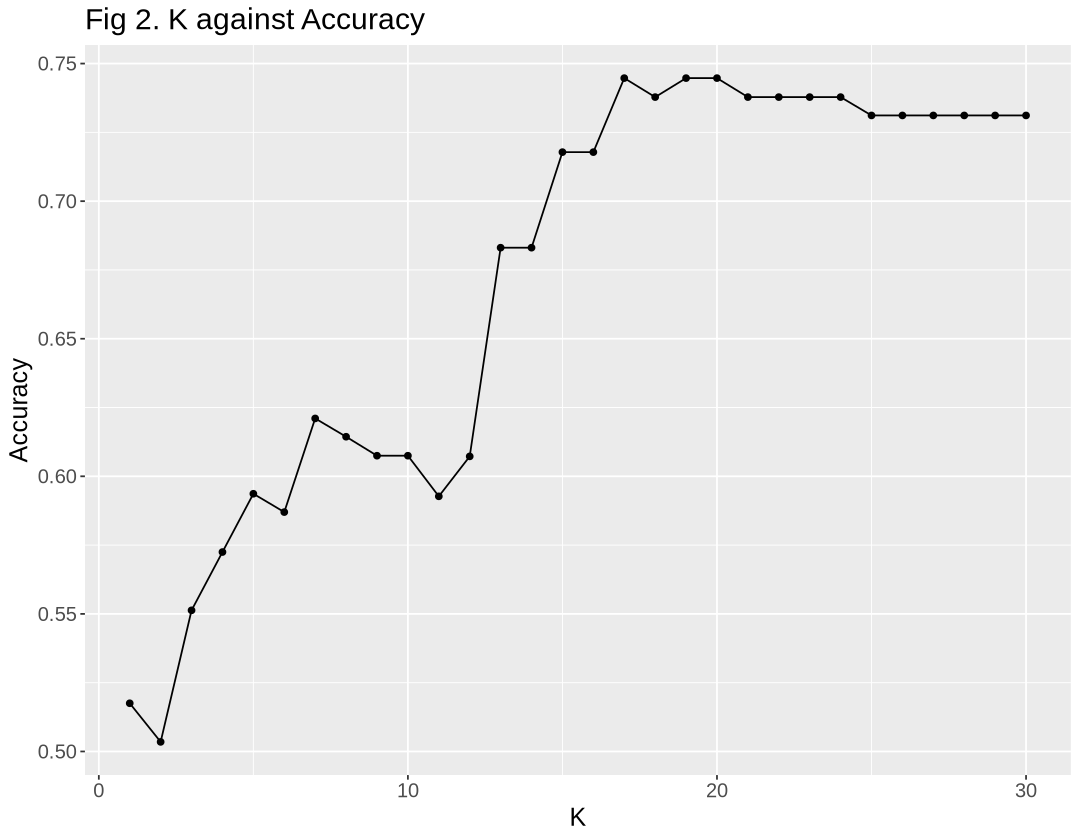

In [9]:
accuracy_plot <- player_fit_tune |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "Accuracy", title = "Fig 2. K against Accuracy") +
    theme(text = element_text(size = 15))

accuracy_plot

It seems like k = 17 would produce the highest accuracy, so let's now fit the training data on our model.

In [10]:
final_player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
    set_engine("kknn") |>
    set_mode("classification")

final_player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(final_player_spec) |>
    fit(player_training)


Finally, we can use our model on our test set to evaluate its accuracy.

In [11]:
player_predict <- predict(final_player_fit, player_testing) |>
    bind_cols(player_testing) |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
player_predict


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776


Our final model's accuracy is 69%, using KNN classification and k = 17.

## DISCUSSION

Comparing the results with the visualization made before (fig. 1), the accuracy is not bad, and perhaps higher than expected! This suggests that these predictors may in fact play a role in whether someone decides to subscribe to a newsletter involving video games. This could be useful for game developers or any researchers studying video game enjoyers, as they may choose to target certain ages or players with a certain amount of hours clocked on a video game. However, a 69% accuracy still leaves much room for error, and based on both the scatterplot (fig. 1) where there seems to be little patterns in the datapoints, and the line graph (fig. 2) that seems to be random as well, we can infer that these are likely not the only nor the strongest predictors for newsletter subscriptions. Some other predictors that could be studied are gender, experience level, or types of games played. Another area of exploration could be studying whether only using one of these predictors would lead to a higher accuracy. Furthermore, a larger dataset with more observations could improve or change our analysis. To take it even further, one could then ask: does subscribing to a game related newsletter actually indicate anything about how they play video games? These are all questions that could be explored using visualizations and classifications with enough data. 
